In [16]:
# import all the gods
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

In [17]:
# data was once loaded to compute mean and std as tensor(0.1307), tensor(0.3081) respectively
train_mnist_set = torchvision.datasets.MNIST(root = '/data', train = True, download = True, transform=transforms.Compose([
                                                                                                                    transforms.ToTensor(),
                                                                                                                    transforms.Normalize((0.1307,), (0.3081,))
]))

In [18]:
# create the Dataset class
from torch.utils.data import Dataset

class MNIST_number(Dataset):
  def __init__(self, mnist_set):
    # use MNIST data
    self.image_data = mnist_set
    self.length = len(mnist_set.train_labels)
    # create a random number
    self.rand_nos = torch.randint(high = 10, size = (self.length, 1))
    self.one_hot_rands = F.one_hot(self.rand_nos)
  
  def __getitem__(self, index):
    # return data and labels for both the MNIST digit detector and random number generator
    image_sample, image_label = self.image_data[index]
    number_sample = self.one_hot_rands[index]
    number_label = self.rand_nos[index].item()
    return (image_sample, number_sample), (image_label, number_label+image_label)

  def __len__(self):
    return self.length

train_set = MNIST_number(train_mnist_set)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:54: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [19]:
# view if output of dataset class is correct
sample = next(iter(train_set))

(image, number_data), (label, number_label) = sample
number_data, number_label

(tensor([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]]), 7)

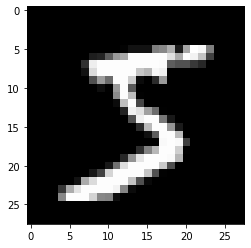

In [20]:
# view the image
import matplotlib.pyplot as plt

plt.imshow(image.squeeze(0), cmap = 'gray')

In [21]:
# create a DataLoader to provide batch input for the defined Dataset class
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size = 100, shuffle = True)

In [22]:
# test loader
images, labels = next(iter(train_loader))

labels,images[1]

([tensor([5, 7, 3, 8, 4, 9, 6, 3, 1, 4, 0, 2, 2, 5, 3, 5, 5, 6, 6, 3, 6, 7, 9, 2,
          2, 5, 0, 7, 6, 1, 2, 8, 5, 0, 5, 7, 7, 8, 8, 7, 7, 1, 3, 4, 7, 6, 4, 9,
          1, 6, 4, 9, 8, 6, 0, 0, 0, 7, 4, 2, 8, 1, 3, 2, 9, 9, 0, 7, 5, 2, 9, 1,
          5, 4, 0, 8, 9, 2, 9, 5, 4, 1, 0, 1, 6, 1, 5, 4, 0, 4, 6, 8, 5, 5, 3, 7,
          4, 7, 7, 3]),
  tensor([11,  9, 11, 15,  8, 16, 13, 10,  2,  7,  3,  9,  9,  9, 12, 12, 10,  8,
           8,  5, 10, 15, 10, 10,  6,  6,  9,  9, 14,  1,  3, 14, 14,  9,  6, 11,
           7, 17, 15, 12,  8,  4,  9,  5,  8,  7,  7, 13,  9,  7,  6, 16, 16,  6,
           0,  8,  6, 14, 11, 11, 17,  7,  6,  2, 16, 13,  5, 16,  6,  3, 11,  5,
          11,  8,  6, 13, 14,  5, 11,  5,  5,  6,  4, 10, 10,  6,  7, 12,  4,  9,
          12, 11,  9, 11, 12, 10,  7, 15, 12, 10])],
 tensor([[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]],
 
         [[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]],
 
         [[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]],
 
         [[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]],
 
     

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


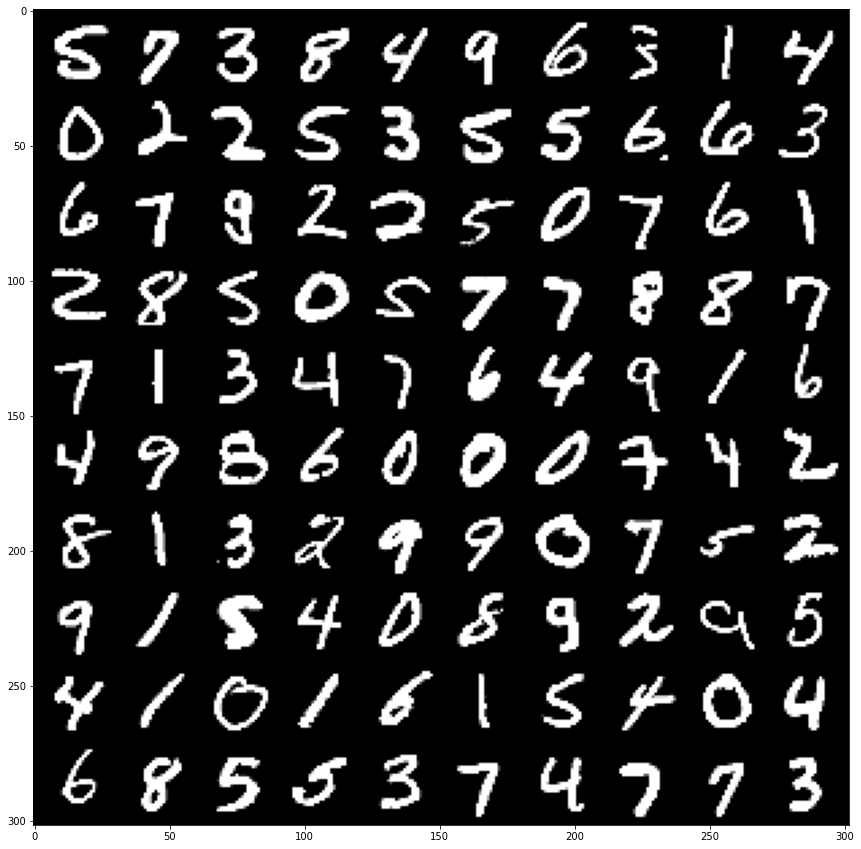

In [23]:
# view a bunch of digits
from torchvision.utils import make_grid
import numpy as np

grid = make_grid(images[0], nrow = 10)
# grid.shape
plt.figure(figsize = (15, 15))
plt.imshow(np.transpose(grid, (1,2,0)))

# Build Network for MNIST
Since we do not yet know what CNN architecture works best for MNIST, let us first take that up as a task and ascertain the conv layers to be used for best results on MNIST

In [24]:
# One approach to perform the multioutput classification
class Network_MNIST_number(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size=3, bias = False)
    self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size=3, bias = False)
    self.bottleneck1 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=1, bias = False)
    self.conv3 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size=3, bias = False)
    self.conv4 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size=3, bias = False)
    self.bottleneck2 = nn.Conv2d(in_channels=32, out_channels=10, kernel_size=1, bias = False)

    self.fc1 = nn.Linear(in_features=20, out_features=50, bias = False)
    self.fc2 = nn.Linear(in_features=50, out_features=50, bias = False)
    self.fc3 = nn.Linear(in_features = 50, out_features = 10, bias = False)
    self.fc4 = nn.Linear(in_features = 50, out_features = 19, bias = False)

  def forward(self, data):
    image, number = data[0], data[1]

    image = self.conv1(image) # in: 28x28, out: 26x26 RF: 3x3
    image = F.relu(image)

    image = self.conv2(image) # in: 26x26, out: 24x24 RF: 5x5
    image = F.relu(image)

    image = F.max_pool2d(image, kernel_size=2, stride = 2)  # in: 24x24, out: 12x12 RF: 10x10
    image = self.bottleneck1(image)# reduction in number of channels from 16 to 8 using 1x1

    image = self.conv3(image)  # in: 12x12, out: 10x10 RF: 12x12
    image = F.relu(image)

    image = self.conv4(image) # in: 10x10, out: 8x8 RF: 14x14

    image = self.bottleneck2(image) # reduction in number of channels from 32 to 10 using 1x1
    image = F.adaptive_avg_pool2d(image, (1, 1)) # in: 8x8, out: 1x1 RF: 14x14

    image = image.reshape(-1, 10)
    data = torch.cat((image, number.squeeze(dim = 1)), dim = 1) # take the random number input

    data = self.fc1(data) # go through fc layer 20 x 50
    data = self.fc2(data) # go through fc layer 50 x 50
    data1 = self.fc3(data) # go through fc layer 50 x 10
    data2 = self.fc4(data) # go through fc layer 50 x 19

    return data1, data2

In [25]:
# alternate network
import torch.nn as nn
import torch.nn.functional as F
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5) #image size = 28*28
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5) #image size 24*24
        # self.dropout1 = nn.Dropout2d(0.25)
        # self.dropout2 = nn.Dropout2d(0.5)

        # self.fc1 = nn.Linear(in_features=20*4*4+10, out_features=120) #image size 20*20 .
        self.fc1 = nn.Linear(in_features=30, out_features=50) #image size 20*20 . 
        # After flattening 576 input neurons. concatenate the random number so 586
        self.fc2 = nn.Linear(in_features=50, out_features=50)
        self.out1 = nn.Linear(in_features=50, out_features=10)
        # 19 output neurons from 0-18. Out of these 2 should be 1 
        # where the first one will be the mnist number and the second one will be the sum.
        self.out2 = nn.Linear(in_features=50, out_features=19)
        # self.fc1 = nn.Linear(9216, 128)
        # self.fc2 = nn.Linear(128, 10)


    def forward(self, t, t1):
        # (1) input layer
        # t = t
        # t1 = t1


        # (2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # (3) hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = F.adaptive_avg_pool2d(t, (1,1))

        # (4) hidden linear layer
        t = t.reshape(-1, 20)
        t2 = t1.reshape(-1,10)
        t = torch.cat([t,t2], dim=1)
        t = self.fc1(t)
        t = F.relu(t)

        # (5) hidden linear layer
        t = self.fc2(t)
        t = F.relu(t)

        t3 = t
        # (6) output layer
        t = self.out1(t)
        t1 = self.out2(t3)
        # t = F.softmax(t, dim=1)

        return t , t1

In [26]:
# test the forward pass
network = Network_MNIST_number()

data, labels = next(iter(train_set))
preds = network((data[0].unsqueeze(dim = 0), data[1]))
preds

(tensor([[-0.0880, -0.0797, -0.0361, -0.0234, -0.0717,  0.0702,  0.0658, -0.0337,
          -0.0324, -0.0660]], grad_fn=<MmBackward>),
 tensor([[ 0.0060,  0.0152,  0.0243,  0.0707,  0.0542, -0.0307, -0.0048,  0.0008,
          -0.0496, -0.0417, -0.0331,  0.0019,  0.0195,  0.0874, -0.0379,  0.0755,
          -0.0279, -0.0007, -0.0863]], grad_fn=<MmBackward>))

In [27]:
# understand total network params
network = Network_MNIST_number()

total_parameters = 0
for name, parameters in network.named_parameters():
  param_count = parameters.numel()
  print(name, " : ", param_count)
  total_parameters += param_count

total_parameters

conv1.weight  :  72
conv2.weight  :  1152
bottleneck1.weight  :  128
conv3.weight  :  1152
conv4.weight  :  4608
bottleneck2.weight  :  320
fc1.weight  :  1000
fc2.weight  :  2500
fc3.weight  :  500
fc4.weight  :  950


12382

In [28]:
# util function
def get_number_correct(pred, labels):
  return pred.argmax(dim = 1).eq(labels).sum().item()

In [29]:
# use GPU for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [30]:
# perform training in epochs
from tqdm import tqdm
import time
network = Network_MNIST_number().to(device) # move network to GPU
# network = Network().to(device) # move network to GPU
optimizer = optim.Adam(network.parameters(), lr = 0.01)
train_loader = DataLoader(train_set, batch_size = 100, shuffle = True)

epochs = 10

for i in range(epochs):
  total_loss = 0
  total_correct_imgs = 0
  total_correct_numbers = 0
  total_batches = 0

  loop = tqdm(train_loader)
  for data, labels in loop:
    # move data to GPU
    images = data[0].to(device = device)
    numbers = data[1].to(device = device)
    image_labels = labels[0].to(device = device)
    number_labels = labels[1].to(device = device)

    # perform forward pass: run through network and compute the loss
    preds = network((images, numbers))
    loss_image = F.cross_entropy(preds[0], image_labels)
    loss_number = F.cross_entropy(preds[1], number_labels)
    loss = loss_image + loss_number

    # perform backward pass: calculate gradients and update weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # monitoring bit
    total_loss += loss.item()
    total_correct_imgs += get_number_correct(preds[0], image_labels) 
    total_correct_numbers += get_number_correct(preds[1], number_labels)
    total_correct = total_correct_imgs + total_correct_numbers
    total_batches += 2 * len(image_labels)

    loop.set_description(f"Epoch [{i+1}/{epochs}]")
    loop.set_postfix(loss = loss.item(), accuracy = total_correct/total_batches)

  print("\n Epoch {0} \n Final metrics -> avg.loss : {1} acc_imgs : {2} acc_numbers : {3}".format(i + 1, 
                            total_loss/len(train_loader), total_correct_imgs/train_set.length, total_correct_numbers/train_set.length))
  time.sleep(1)


Epoch [1/10]: 100%|██████████| 600/600 [00:16<00:00, 36.36it/s, accuracy=0.459, loss=1.93]



 Epoch 1 
 Final metrics -> avg.loss : 2.8836028679211934 acc_imgs : 0.6651333333333334 acc_numbers : 0.25243333333333334


Epoch [2/10]: 100%|██████████| 600/600 [00:15<00:00, 37.52it/s, accuracy=0.663, loss=1.44]



 Epoch 2 
 Final metrics -> avg.loss : 1.7453636066118876 acc_imgs : 0.9327166666666666 acc_numbers : 0.3937


Epoch [3/10]: 100%|██████████| 600/600 [00:15<00:00, 38.16it/s, accuracy=0.688, loss=1.67]



 Epoch 3 
 Final metrics -> avg.loss : 1.6084052356084189 acc_imgs : 0.9489333333333333 acc_numbers : 0.42656666666666665


Epoch [4/10]: 100%|██████████| 600/600 [00:14<00:00, 40.72it/s, accuracy=0.699, loss=1.28]



 Epoch 4 
 Final metrics -> avg.loss : 1.5483437979221344 acc_imgs : 0.9562166666666667 acc_numbers : 0.4425


Epoch [5/10]: 100%|██████████| 600/600 [00:14<00:00, 41.14it/s, accuracy=0.71, loss=1.36]



 Epoch 5 
 Final metrics -> avg.loss : 1.4925283195575079 acc_imgs : 0.9602333333333334 acc_numbers : 0.46013333333333334


Epoch [6/10]: 100%|██████████| 600/600 [00:14<00:00, 41.10it/s, accuracy=0.714, loss=1.28]



 Epoch 6 
 Final metrics -> avg.loss : 1.4785029943784078 acc_imgs : 0.9613333333333334 acc_numbers : 0.46708333333333335


Epoch [7/10]: 100%|██████████| 600/600 [00:14<00:00, 41.11it/s, accuracy=0.72, loss=1.36]



 Epoch 7 
 Final metrics -> avg.loss : 1.44892280737559 acc_imgs : 0.9633166666666667 acc_numbers : 0.47678333333333334


Epoch [8/10]: 100%|██████████| 600/600 [00:14<00:00, 41.04it/s, accuracy=0.726, loss=1.46]



 Epoch 8 
 Final metrics -> avg.loss : 1.423820413351059 acc_imgs : 0.9648 acc_numbers : 0.48755


Epoch [9/10]: 100%|██████████| 600/600 [00:14<00:00, 41.26it/s, accuracy=0.725, loss=1.26]



 Epoch 9 
 Final metrics -> avg.loss : 1.4205640800793966 acc_imgs : 0.9643333333333334 acc_numbers : 0.48468333333333335


Epoch [10/10]: 100%|██████████| 600/600 [00:14<00:00, 40.92it/s, accuracy=0.734, loss=1.24]



 Epoch 10 
 Final metrics -> avg.loss : 1.3868597594896952 acc_imgs : 0.9669666666666666 acc_numbers : 0.5013833333333333


### Adder Network

Since the adder network seems to be underperforming, let's try writing a separate network and finalize the structure for the adder!

In [ ]:
import torch

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# create dataset
from torch.utils.data import Dataset
import torch.nn.functional as F

class two_numbers(Dataset):
  def __init__(self):
    self.length = 50000
    self.number1 = torch.randint(high = 10, size = (self.length, 1))
    self.number2 = torch.randint(high = 10, size = (self.length, 1))
    self.out = self.number1 + self.number2
    self.number1_enc = F.one_hot(self.number1).float()
    self.number2_enc = F.one_hot(self.number2).float()

  def __getitem__(self, index):
    return (self.number1_enc[index], self.number2_enc[index]), self.out[index].item()

  def __len__(self):
    return self.length

In [ ]:
# create dataloader
from torch.utils.data import DataLoader
num_set = two_numbers()

num_loader = DataLoader(num_set, batch_size = 50000, shuffle = True)

In [ ]:
import torch.nn as nn

class adder_network(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(in_features = 20, out_features = 50)
    self.fc2 = nn.Linear(in_features = 50, out_features = 50)
    self.fc3 = nn.Linear(in_features = 50, out_features = 19)

  def forward(self, inputs):
    
    data = torch.cat((inputs[0], inputs[1]), dim = 2)
    data.reshape(-1, 20)

    data = self.fc1(data)
    data = F.relu(data)

    data = self.fc2(data)
    data = F.relu(data)

    out = self.fc3(data)
    out = out.reshape(-1, 19)
    # out = F.softmax(out, dim = 1)

    return out

In [ ]:
def get_correct_preds(pred, label):
  return pred.argmax(dim = 1).eq(label).sum().item()

In [ ]:
from tqdm import tqdm
import torch.optim as optim

network = adder_network().to(device = device)
optimizer = optim.Adam(network.parameters(), lr = 0.01)

num_epochs = 20

for i in range(num_epochs):

  total_loss = 0
  total_correct = 0
  total_batches = 0
  tot_iters = 0

  loop = tqdm(num_loader)
  for inputs, label in loop:
    input1 = inputs[0].to(device = device)
    input2 = inputs[1].to(device = device)
    label = label.to(device = device)

    pred = network((input1, input2))
    loss = F.cross_entropy(pred, label)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    total_correct = get_correct_preds(pred, label)
    total_batches += len(label)
    tot_iters += 1

    loop.set_description(f"Epoch {i+1}/{num_epochs}")
    loop.set_postfix(loss = loss.item(), avg_loss = total_loss/tot_iters, acc = total_correct/total_batches)


Epoch 1/20: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s, acc=0.0595, avg_loss=2.97, loss=2.97]

Epoch 2/20: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s, acc=0.0706, avg_loss=2.93, loss=2.93]

Epoch 3/20: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s, acc=0.0996, avg_loss=2.9, loss=2.9]

Epoch 4/20: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s, acc=0.089, avg_loss=2.87, loss=2.87]

Epoch 5/20: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s, acc=0.0993, avg_loss=2.84, loss=2.84]

Epoch 6/20: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s, acc=0.0993, avg_loss=2.8, loss=2.8]

Epoch 7/20: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s, acc=0.0985, avg_loss=2.78, loss=2.78]

Epoch 8/20: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s, acc=0.0985, avg_loss=2.76, loss=2.76]

Epoch 9/20: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s, acc=0.108, avg_loss=2.77, loss=2.77]

Epoch 10/20: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s, acc=0.12, avg_loss=2.79, loss=2.79]

Epoch 11/20: 100%|██████████| 1/1 [0

After trying a few different combinations, turns out a simple network is not able to learn addition well. Even with running 500 epochs, only 50 pc acc was achieved. Perhaps trying a different representation such as a regression approach, would result in closer predictions.